In [ ]:
import torch
import torch.nn as nn
import math
import sys
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

sys.path.append(str(Path.cwd().parent))
project_root = Path.cwd().parent

torch.manual_seed(0)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Running on: {device}")

Running on: mps


In [2]:
from src.models.architectures.canonical_transformer import TransformerEDBaselineAR
from src.models.architectures.mat import MATED  

## Tests données simulées

### Transformer canonique

In [3]:
class SimulatedFinancialDataset(Dataset):
    def __init__(self, N=2000, T=60, F=12, H=5, seed=0):
        super().__init__()
        rng = np.random.default_rng(seed)
        self.T, self.F, self.H = T, F, H

        # --- série latente s_t (random walk lisse) ---
        # longueur totale: T + H + 1 pour pouvoir construire y_hist et y_future
        L = T + H + 1
        s = np.cumsum(rng.normal(0, 0.3, size=(N, L)), axis=1)  # [N, L]

        # --- features numériques corrélées à s_t ---
        x_num = []
        for j in range(F):
            noise = rng.normal(0, 0.5, size=(N, L))
            x_num.append((0.7 + 0.05*j) * s + noise)
        x_num = np.stack(x_num, axis=-1)  # [N, L, F]

        # --- sentiments (5) corrélés différemment à s_t ---
        x_sent = rng.normal(0, 1.0, size=(N, L, 5))
        x_sent[..., 0] += 0.3 * s
        x_sent[..., 1] += -0.2 * s

        # --- embeddings (768) : bruit + un petit signal ---
        x_emb = rng.normal(0, 1.0, size=(N, L, 768))
        x_emb[..., 0] += 0.1 * s
        x_emb[..., 1] += -0.1 * s

        # --- “retours” : y_{t+1} dépend de s_{t+1}-s_t + un peu des features ---
        ret = (s[:, 1:] - s[:, :-1]) + 0.05 * x_num[:, :-1, 0] + rng.normal(0, 0.1, size=(N, L-1))
        # ret a longueur L-1, index k = retour entre s_k et s_{k+1}  => c’est "target à date k"
        # Donc ret[:, t] correspond à y_{t+1} si on interprète t comme "date t"

        self.x_num = torch.tensor(x_num[:, :T, :], dtype=torch.float32)      # [N,T,F]
        self.x_sent = torch.tensor(x_sent[:, :T, :], dtype=torch.float32)    # [N,T,5]
        self.x_emb = torch.tensor(x_emb[:, :T, :], dtype=torch.float32)      # [N,T,768]

        # Repère:
        # fin de fenêtre = t = T-1
        # y_hist = [y_t, ..., y_{t+H-1}]  = ret[t-1 : t-1+H]
        # y_future = [y_{t+1}, ..., y_{t+H}] = ret[t : t+H]
        t = T - 1
        self.y_hist = torch.tensor(ret[:, t-1 : t-1+H], dtype=torch.float32)     # [N,H]
        self.y_future = torch.tensor(ret[:, t : t+H], dtype=torch.float32)       # [N,H]

    def __len__(self):
        return self.x_num.size(0)

    def __getitem__(self, idx):
        return {
            "x_num": self.x_num[idx],
            "x_sent": self.x_sent[idx],
            "x_emb": self.x_emb[idx],
            "y_hist": self.y_hist[idx],
            "y_future": self.y_future[idx],
        }

T, F, H = 60, 12, 1
ds = SimulatedFinancialDataset(N=3000, T=T, F=F, H=H, seed=0)
train_ds, test_ds = torch.utils.data.random_split(ds, [2500, 500], generator=torch.Generator().manual_seed(0))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

batch = next(iter(train_loader))
for k,v in batch.items():
    print(k, v.shape)

x_num torch.Size([64, 60, 12])
x_sent torch.Size([64, 60, 5])
x_emb torch.Size([64, 60, 768])
y_hist torch.Size([64, 1])
y_future torch.Size([64, 1])


In [4]:
model = TransformerEDBaselineAR(
    num_input_dim=F,
    n_sent=5,
    d_model=128,
    nhead=4,
    enc_layers=2,
    dec_layers=2,
    dropout=0.2,
    forecast_horizon=1
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)


/Users/brianramesh/Documents/ MAT_implementation/.venv/lib/python3.13/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [5]:
from tqdm.auto import tqdm

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    n = 0

    pbar = tqdm(loader, desc="train", leave=False)
    for batch in pbar:
        x_num   = batch["x_num"].to(device)
        x_sent  = batch["x_sent"].to(device)
        x_emb   = batch["x_emb"].to(device)
        y_hist  = batch["y_hist"].to(device)
        y_true  = batch["y_future"].to(device)

        y_hat = model(x_num, x_sent, x_emb, y_hist)
        loss = criterion(y_hat, y_true)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        bs = x_num.size(0)
        total_loss += loss.item() * bs
        n += bs

        pbar.set_postfix(loss=total_loss / n)

    return total_loss / n


@torch.no_grad()
def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    n = 0

    pbar = tqdm(loader, desc="eval", leave=False)
    for batch in pbar:
        x_num   = batch["x_num"].to(device)
        x_sent  = batch["x_sent"].to(device)
        x_emb   = batch["x_emb"].to(device)
        y_hist  = batch["y_hist"].to(device)
        y_true  = batch["y_future"].to(device)

        y_hat = model(x_num, x_sent, x_emb, y_hist)
        loss = criterion(y_hat, y_true)

        bs = x_num.size(0)
        total_loss += loss.item() * bs
        n += bs

        pbar.set_postfix(loss=total_loss / n)

    return total_loss / n


num_epochs = 10
for epoch in range(num_epochs):
    tr = train_one_epoch(model, train_loader, optimizer, criterion, device)
    te = eval_one_epoch(model, test_loader, criterion, device)
    print(f"epoch {epoch:02d} | train {tr:.4f} | test {te:.4f}")

/Users/brianramesh/Documents/ MAT_implementation/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


epoch 00 | train 0.1236 | test 0.1021


epoch 01 | train 0.1055 | test 0.1020


epoch 02 | train 0.1037 | test 0.1002


epoch 03 | train 0.1024 | test 0.1019


epoch 04 | train 0.1019 | test 0.0981


epoch 05 | train 0.1021 | test 0.0994


epoch 06 | train 0.0987 | test 0.1008


epoch 07 | train 0.0940 | test 0.1542


epoch 08 | train 0.0810 | test 0.1266


epoch 09 | train 0.0694 | test 0.2117


epoch 10 | train 0.0606 | test 0.1528


epoch 11 | train 0.0508 | test 0.1787


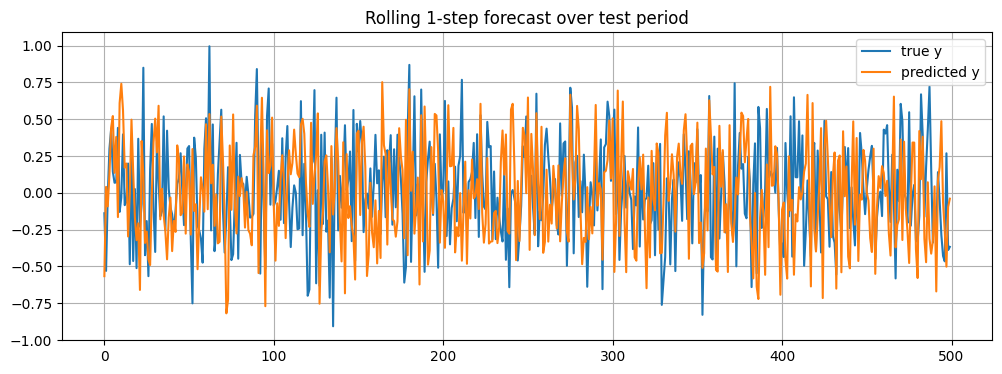

In [6]:
all_true = []
all_pred = []

model.eval()

for batch in test_loader:
    x_num  = batch["x_num"].to(device)
    x_sent = batch["x_sent"].to(device)
    x_emb  = batch["x_emb"].to(device)
    y_hist = batch["y_hist"].to(device)
    y_true = batch["y_future"].to(device)

    with torch.no_grad():
        y_pred = model.predict(x_num, x_sent, x_emb, y_hist[:, 0])

    # on prend horizon 1
    all_true.append(y_true[:, 0].cpu())
    all_pred.append(y_pred[:, 0].cpu())

all_true = torch.cat(all_true).numpy()
all_pred = torch.cat(all_pred).numpy()

plt.figure(figsize=(12,4))
plt.plot(all_true, label="true y")
plt.plot(all_pred, label="predicted y")
plt.title("Rolling 1-step forecast over test period")
plt.legend()
plt.grid(True)
plt.show()

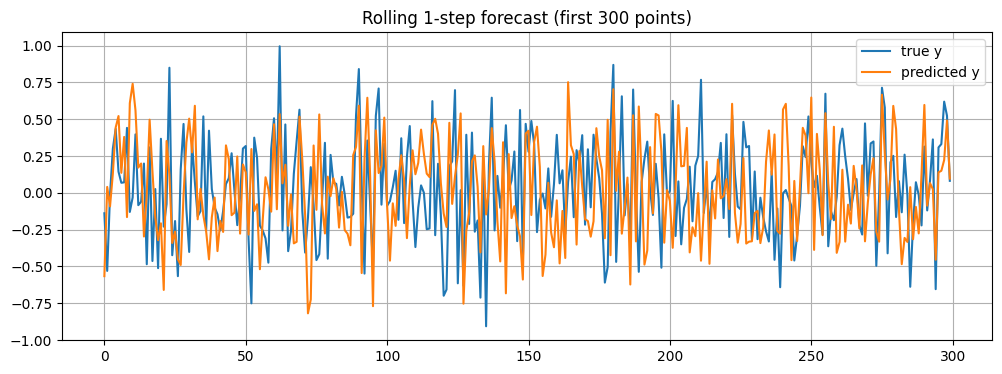

In [7]:
k = 300  # nb de points à afficher

plt.figure(figsize=(12,4))
plt.plot(all_true[:k], label="true y")
plt.plot(all_pred[:k], label="predicted y")
plt.title(f"Rolling 1-step forecast (first {k} points)")
plt.legend()
plt.grid(True)
plt.show()

### Transformer MAT

In [8]:
H = 1  # horizon
F = 12 # num_input_dim

mat_plain = MATED(
    num_input_dim=F,
    n_sent=5,
    d_model=128,
    nhead=4,
    enc_layers=2,
    dec_layers=2,
    dropout=0.2,
    forecast_horizon=H,
    encoder_type="plain",      # <- IMPORTANT
).to(device)

mat_weighted = MATED(
    num_input_dim=F,
    n_sent=5,
    d_model=128,
    nhead=4,
    enc_layers=2,
    dec_layers=2,
    dropout=0.2,
    forecast_horizon=H,
    encoder_type="weighted",   # <- IMPORTANT
).to(device)

criterion = nn.MSELoss()

opt_plain = torch.optim.AdamW(mat_plain.parameters(), lr=3e-4, weight_decay=1e-4)
opt_weighted = torch.optim.AdamW(mat_weighted.parameters(), lr=3e-4, weight_decay=1e-4)

In [9]:
from tqdm.auto import tqdm

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    n = 0

    pbar = tqdm(loader, desc="train", leave=False)
    for batch in pbar:
        x_num   = batch["x_num"].to(device)
        x_sent  = batch["x_sent"].to(device)
        x_emb   = batch["x_emb"].to(device)
        y_hist  = batch["y_hist"].to(device)
        y_true  = batch["y_future"].to(device)

        y_hat = model(x_num, x_sent, x_emb, y_hist)  # teacher forcing
        loss = criterion(y_hat, y_true)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        bs = x_num.size(0)
        total_loss += loss.item() * bs
        n += bs
        pbar.set_postfix(loss=total_loss / n)

    return total_loss / n


@torch.no_grad()
def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    n = 0

    pbar = tqdm(loader, desc="eval", leave=False)
    for batch in pbar:
        x_num   = batch["x_num"].to(device)
        x_sent  = batch["x_sent"].to(device)
        x_emb   = batch["x_emb"].to(device)
        y_hist  = batch["y_hist"].to(device)
        y_true  = batch["y_future"].to(device)

        y_hat = model(x_num, x_sent, x_emb, y_hist)
        loss = criterion(y_hat, y_true)

        bs = x_num.size(0)
        total_loss += loss.item() * bs
        n += bs
        pbar.set_postfix(loss=total_loss / n)

    return total_loss / n

In [18]:
num_epochs = 10

print("=== TRAIN MAT plain ===")
for epoch in range(num_epochs):
    tr = train_one_epoch(mat_plain, train_loader, opt_plain, criterion, device)
    te = eval_one_epoch(mat_plain, test_loader, criterion, device)
    print(f"epoch {epoch:02d} | train {tr:.4f} | test {te:.4f}")

print("\n=== TRAIN MAT weighted ===")
for epoch in range(num_epochs):
    tr = train_one_epoch(mat_weighted, train_loader, opt_weighted, criterion, device)
    te = eval_one_epoch(mat_weighted, test_loader, criterion, device)
    print(f"epoch {epoch:02d} | train {tr:.4f} | test {te:.4f}")

=== TRAIN MAT plain ===


epoch 00 | train 0.0617 | test 0.1847


epoch 01 | train 0.0485 | test 0.1372


epoch 02 | train 0.0391 | test 0.1268


epoch 03 | train 0.0349 | test 0.1371


epoch 04 | train 0.0312 | test 0.1320


epoch 05 | train 0.0253 | test 0.1292


epoch 06 | train 0.0275 | test 0.1258


epoch 07 | train 0.0233 | test 0.1241


epoch 08 | train 0.0197 | test 0.1286


epoch 09 | train 0.0192 | test 0.1272

=== TRAIN MAT weighted ===


epoch 00 | train 0.0511 | test 0.1335


epoch 01 | train 0.0416 | test 0.1249


epoch 02 | train 0.0357 | test 0.1425


epoch 03 | train 0.0331 | test 0.1436


epoch 04 | train 0.0277 | test 0.1358


epoch 05 | train 0.0242 | test 0.1296


epoch 06 | train 0.0265 | test 0.1565


epoch 07 | train 0.0233 | test 0.1287


epoch 08 | train 0.0191 | test 0.1245


epoch 09 | train 0.0183 | test 0.1400


In [19]:
def collect_rolling_1step_preds(model, loader, device, max_points=None):
    all_true, all_pred = [], []
    model.eval()

    with torch.no_grad():
        for batch in loader:
            x_num  = batch["x_num"].to(device)
            x_sent = batch["x_sent"].to(device)
            x_emb  = batch["x_emb"].to(device)
            y_hist = batch["y_hist"].to(device)
            y_true = batch["y_future"].to(device)

            y0 = y_hist[:, 0]              # y_t
            y_pred = model.predict(x_num, x_sent, x_emb, y0)

            all_true.append(y_true[:, 0].cpu())
            all_pred.append(y_pred[:, 0].cpu())

            if max_points is not None:
                if sum(t.numel() for t in all_true) >= max_points:
                    break

    all_true = torch.cat(all_true).numpy()
    all_pred = torch.cat(all_pred).numpy()

    if max_points is not None:
        all_true = all_true[:max_points]
        all_pred = all_pred[:max_points]

    return all_true, all_pred

In [20]:
K = 300  # nombre de points affichés

true_plain, pred_plain = collect_rolling_1step_preds(
    mat_plain, test_loader, device, max_points=K
)

true_weighted, pred_weighted = collect_rolling_1step_preds(
    mat_weighted, test_loader, device, max_points=K
)

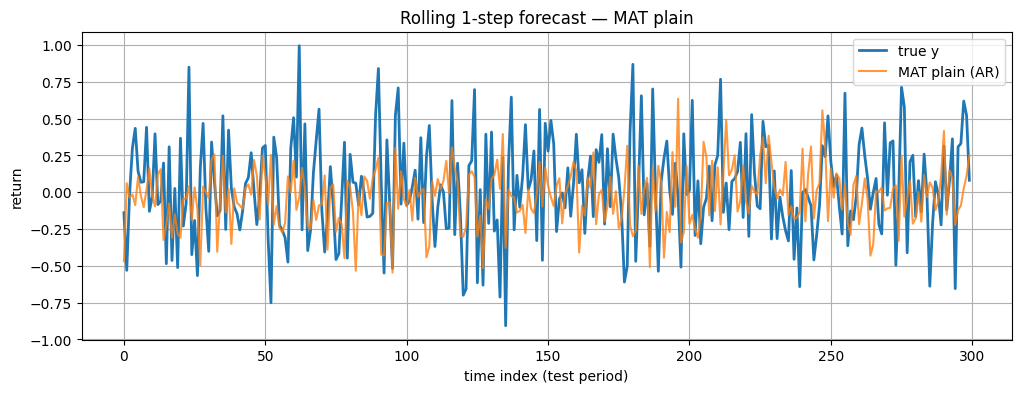

In [21]:
plt.figure(figsize=(12,4))
plt.plot(true_plain, label="true y", linewidth=2)
plt.plot(pred_plain, label="MAT plain (AR)", alpha=0.8)

plt.title("Rolling 1-step forecast — MAT plain")
plt.xlabel("time index (test period)")
plt.ylabel("return")
plt.legend()
plt.grid(True)
plt.show()

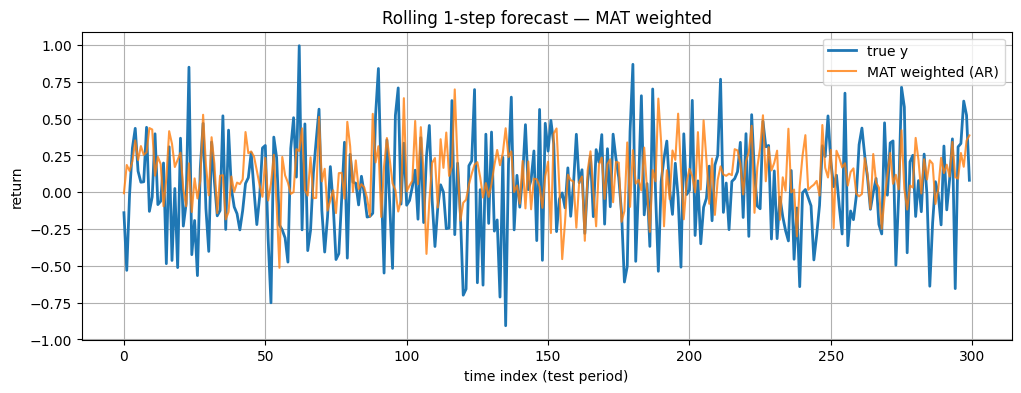

In [22]:
plt.figure(figsize=(12,4))
plt.plot(true_weighted, label="true y", linewidth=2)
plt.plot(pred_weighted, label="MAT weighted (AR)", alpha=0.8)

plt.title("Rolling 1-step forecast — MAT weighted")
plt.xlabel("time index (test period)")
plt.ylabel("return")
plt.legend()
plt.grid(True)
plt.show()

In [23]:
rmse_transfo = np.sqrt(np.mean((all_true - all_pred)**2))
rmse_plain = np.sqrt(np.mean((true_plain - pred_plain)**2))
rmse_weighted = np.sqrt(np.mean((true_weighted - pred_weighted)**2))

print(f"RMSE Transfo    : {rmse_transfo:.4f}")
print(f"RMSE MAT plain    : {rmse_plain:.4f}")
print(f"RMSE MAT weighted : {rmse_weighted:.4f}")

RMSE Transfo    : 0.4227
RMSE MAT plain    : 0.3666
RMSE MAT weighted : 0.3802
